In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import h5py

In [23]:
import string_constants as sc
import reading_util as ru
import writing_util as wu
import dataset_util as du
import parameter as pa
import quantile_regression_dnn as qr
import data_sample as ds
import plotting_util as pu
import plotting_util_analysis as pua
import flat_cut as fc
import selector as sr
import booster as bo
import parameter as pa

In [24]:
from histo_utilities import *
import ROOT as rt

# runtime parameters

In [25]:
# share of total qcd signal region data for QR training (rest for GOF test)
QR_train_share = 0.25 #0.2
# constant fraction wrt dijet mass of BG accepted
quantile = pa.quantile_dict['q1'] # q1 = 1%
# strategy for combining loss-jet-1 and loss-jet-2
strategy = pa.loss_strategy_dict['s5'] # s5 = L1 & L2

# read in data (qcd and signal)

In [26]:
SM_sample = 'qcdSigAll'
qcd_path = os.path.join( sc.concat_result_dir, sc.sample_loc[SM_sample] + sc.concat_result_suffix )
qcd_data_total = ru.read_results_to_dataframe( qcd_path )

In [27]:
BSM_sample= 'GtoWW30na'
signal_path = os.path.join( sc.concat_result_dir, sc.sample_loc[BSM_sample] + sc.concat_result_suffix )
signal_sample = ds.read_datasample_from_file( 'GtoWW30na', signal_path )

## split qcd data into train and test set 

In [28]:
qcd_data_train, qcd_data_test = du.split_dataset_train_test( qcd_data_total, QR_train_share )

## make qcd_train and qcd_test data samples

In [29]:
qcd_sample_train = ds.DataSample( SM_sample+'_train', qcd_data_train )
qcd_sample_test = ds.DataSample( SM_sample, qcd_data_test )

# Booster

In [30]:
booster = bo.Booster( quantile, strategy, sr.QuantileRegressionOverflowBinSelector ) # sr.FlatCutSelector
booster.train_selector( qcd_sample_train )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total para

In [31]:
booster.save_selector('QR_overflow_model.h5')

# VAE Boost

## get selection for qcd sample

In [32]:
booster.boost_sample( qcd_sample_test )

[1100.0, 1275.3545247395832, 1450.7090494791667, 1626.06357421875, 1801.4180989583333, 1976.7726236979165, 2152.1271484375, 2327.4816731770834, 2502.8361979166666, 2678.19072265625, 2853.545247395833, 3028.8997721354167, 3204.254296875, 3379.608821614583, 3554.963346354167, 3730.31787109375, 3905.672395833333, 4081.0269205729164, 4256.3814453125, 4431.735970052083, 4607.090494791666, 4782.445019531249, 4957.799544270833, 5133.154069010417, 5308.50859375, 5483.863118489583, 5659.217643229166, 5834.572167968749, 6009.926692708334, 6185.281217447917, 6360.6357421875]
[1100.0, 1275.3545247395832, 1450.7090494791667, 1626.06357421875, 1801.4180989583333, 1976.7726236979165, 2152.1271484375, 2327.4816731770834, 2502.8361979166666, 2678.19072265625, 2853.545247395833, 3028.8997721354167, 3204.254296875, 3379.608821614583, 3554.963346354167, 3730.31787109375, 3905.672395833333, 4081.0269205729164, 4256.3814453125, 4431.735970052083, 4607.090494791666, 4782.445019531249, 4957.799544270833, 5133

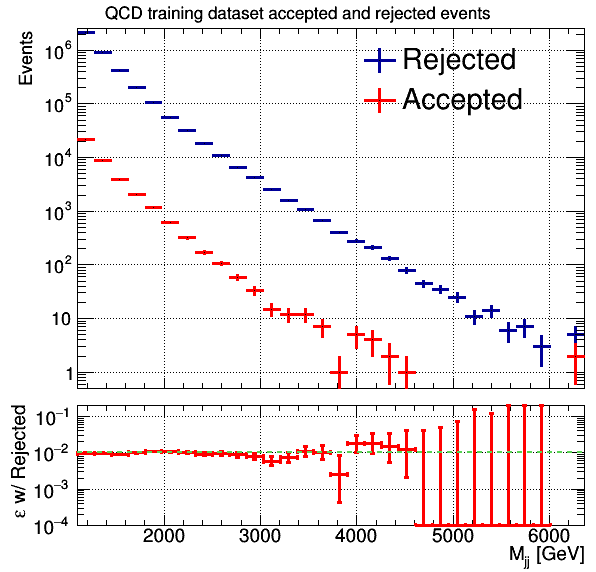

In [33]:
binning=[30, pa.Mjj_selection, qcd_sample_train['mJJ'].max()]
c1 = pua.plotMassSpectrum(qcd_sample_test.accepted('mJJ'), qcd_sample_test.rejected('mJJ'), binning, quantile.val, 'QCD training dataset accepted and rejected events')

## get data from root hist

In [34]:
h_a = c1.h_list[1]
h_r = c1.h_list[0]
acc_bin_counts, _ = rootTH1_to_np(h_a)
rej_bin_counts, _ = rootTH1_to_np(h_r)
bin_edges = [h_a.GetXaxis().GetBinLowEdge(i) for i in range(1,h_a.GetNbinsX()+2)]

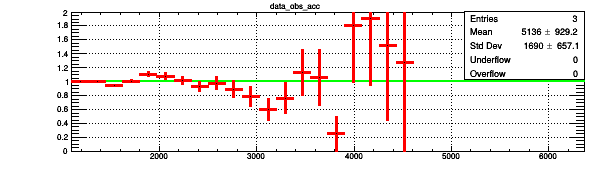

In [35]:
reload(pua)
cc, hh, tt = pua.plotMassSpectrumCombine(acc_bin_counts,rej_bin_counts,bin_edges)
tt.Draw()
hh.Draw('same')
cc.Draw()

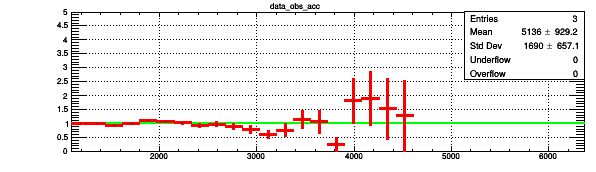

In [36]:
reload(pua)
cc, hh, tt = pua.plotMassSpectrumCombine(acc_bin_counts,rej_bin_counts,bin_edges,y_max=5)
tt.Draw()
hh.Draw('same')
cc.Draw()

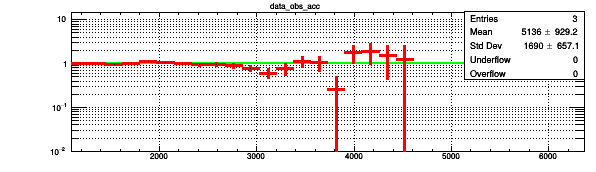

In [37]:
reload(pua)
cc, hh, tt = pua.plotMassSpectrumCombineLogscale(acc_bin_counts,rej_bin_counts,bin_edges)
tt.Draw()
hh.Draw('same')
cc.Draw()

## exotica binning

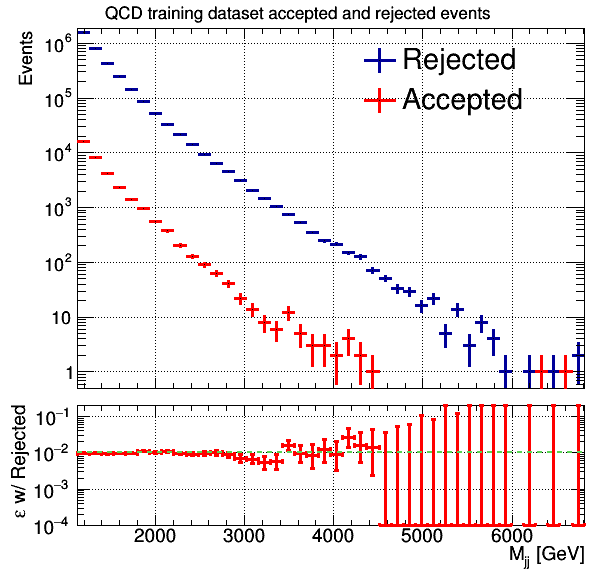

In [38]:
reload(pua)
bin_edges = np.array([1126,1181,1246,1313,1383,1455,1530,1607,1687,1770,1856,1945,2037,2132,2231,2332,2438,2546,2659,2775,2895,3019,3147,3279,3416,3558,3704,3854,4010,4171,4337,4509,4686,4869,5058,5253,5500,5663,5877,6099,6328,6564,6808])
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]
binning = [n_bins, min_bin, max_bin]
c2 = pua.plotMassSpectrum(qcd_sample_test.accepted('mJJ'), qcd_sample_test.rejected('mJJ'), binning, quantile.val, 'QCD training dataset accepted and rejected events')

## get data from root hist

In [39]:
h_a = c2.h_list[1]
h_r = c2.h_list[0]
acc_bin_counts, _ = rootTH1_to_np(h_a)
rej_bin_counts, _ = rootTH1_to_np(h_r)
bin_edges = [h_a.GetXaxis().GetBinLowEdge(i) for i in range(1,h_a.GetNbinsX()+2)]

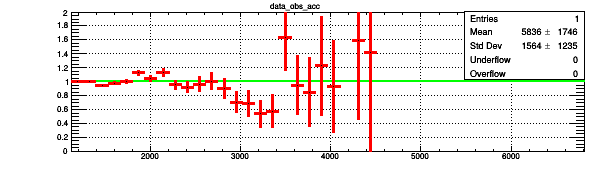

In [40]:
reload(pua)
cc, hh, tt = pua.plotMassSpectrumCombine(acc_bin_counts,rej_bin_counts,bin_edges)
tt.Draw()
hh.Draw('same')
cc.Draw()

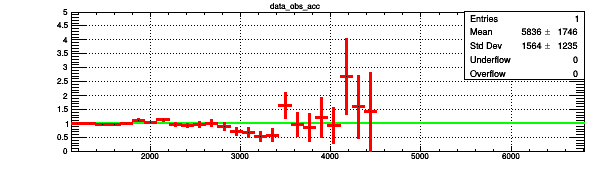

In [41]:
reload(pua)
cc, hh, tt = pua.plotMassSpectrumCombine(acc_bin_counts,rej_bin_counts,bin_edges,y_max=5)
tt.Draw()
hh.Draw('same')
cc.Draw()

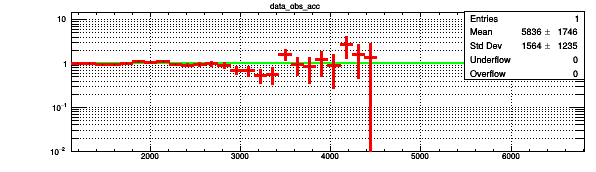

In [42]:
reload(pua)
cc, hh, tt = pua.plotMassSpectrumCombineLogscale(acc_bin_counts,rej_bin_counts,bin_edges)
tt.Draw()
hh.Draw('same')
cc.Draw()

## get selection for signal sample

In [19]:
booster.boost_sample( signal_sample )

In [20]:
#signal_sample.dump(os.path.join(sc.vae_boost_dir,'quant_1pct_loss_maxl1l2/selections/'+BSM_sample+'_sel.h5'))

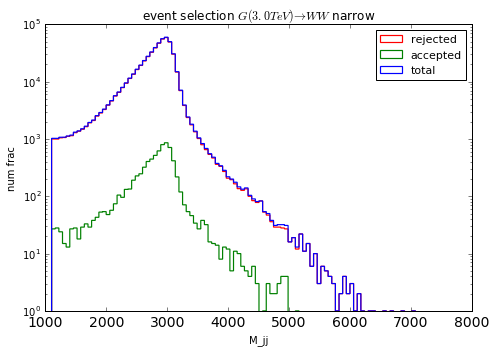

In [21]:
pua.plot_accepted_vs_rejected_hist( signal_sample )

# Binning for bump hunt

In [26]:
bin_edges = [1126,1181,1246,1313,1383,1455,1530,1607,1687,1770,1856,1945,2037,2132,2231,2332,2438,2546,2659,2775,2895,3019,3147,3279,3416,3558,3704,3854,4010,4171,4337,4509,4686,4869,5058,5253,5500,5663,5877,6099,6328,6564,6808]

In [27]:
qcd_tot_cnt, qcd_acc_cnt, qcd_rej_cnt = sr.get_bin_counts_total_acc_rej( qcd_sample, bin_edges )

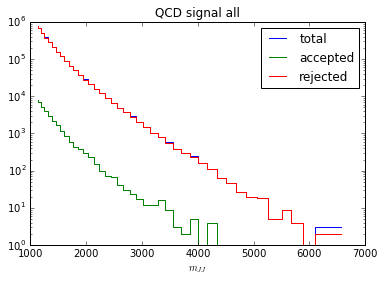

In [28]:
pu.plot_step(bin_edges[:-1],[qcd_tot_cnt, qcd_acc_cnt, qcd_rej_cnt],
             labels=['total','accepted','rejected'],title=qcd_sample.title(),xlabel=r'$m_{JJ}$')

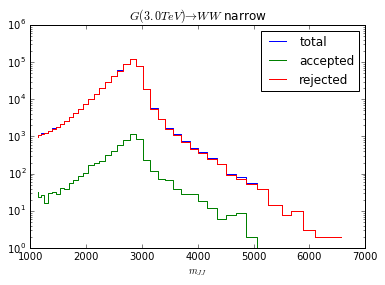

In [29]:
sig_na_tot_cnt, sig_na_acc_cnt, sig_na_rej_cnt = sr.get_bin_counts_total_acc_rej( signal_sample_na, bin_edges )
pu.plot_step(bin_edges[:-1],[sig_na_tot_cnt, sig_na_acc_cnt, sig_na_rej_cnt],
             labels=['total','accepted','rejected'],title=signal_sample_na.title(),xlabel=r'$m_{JJ}$')

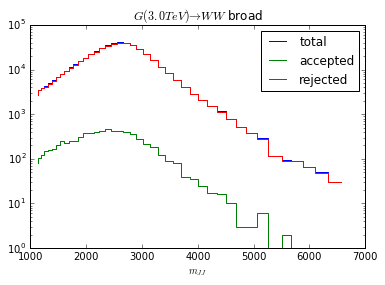

In [30]:
sig_br_tot_cnt, sig_br_acc_cnt, sig_br_rej_cnt = sr.get_bin_counts_total_acc_rej( signal_sample_br, bin_edges )
pu.plot_step(bin_edges[:-1],[sig_br_tot_cnt, sig_br_acc_cnt, sig_br_rej_cnt],
             labels=['total','accepted','rejected'],title=signal_sample_br.title(),xlabel=r'$m_{JJ}$')

# write bincounts

In [31]:
date = datetime.date.today().strftime("%m%d")
bin_file_path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_boost/quant_1pct_loss_maxl1l2/bin_counts_qr_standard_cut_'+date+'.h5'
qcd_counts = np.stack((qcd_tot_cnt,qcd_acc_cnt,qcd_rej_cnt))
sig_na_counts = np.stack((sig_na_tot_cnt,sig_na_acc_cnt,sig_na_rej_cnt))
sig_br_counts = np.stack((sig_br_tot_cnt,sig_br_acc_cnt,sig_br_rej_cnt))
wu.write_bin_counts([SM_sample,BSM_sample_na,BSM_sample_br],[qcd_counts,sig_na_counts,sig_br_counts],bin_edges,bin_file_path)

# check dumped data

In [32]:
bin_file_path

'/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_boost/quant_1pct_loss_maxl1l2/bin_counts_qr_standard_cut_0503.h5'

[u'GtoWW30br', u'GtoWW30na', u'bin_count_labels', u'bin_edges', u'qcdSigAll']


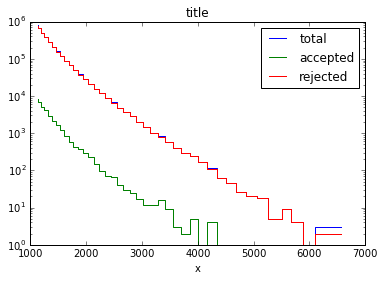

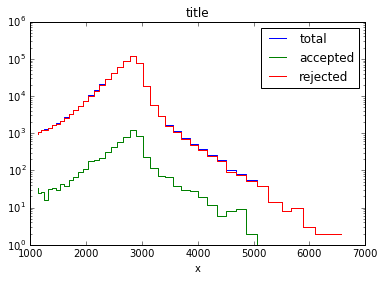

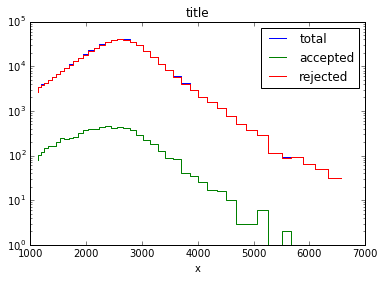

In [33]:
f = h5py.File(bin_file_path,'r')
print(f.keys())
qcd_counts = f.get('qcdSigAll')
sig_counts = f.get('GtoWW30na')
qcd_tot, qcd_acc, qcd_rej = qcd_counts[0], qcd_counts[1], qcd_counts[2]
sig_tot, sig_acc, sig_rej = sig_counts[0], sig_counts[1], sig_counts[2]
pu.plot_step(bin_edges[:-1],[qcd_tot, qcd_acc, qcd_rej],labels=['total','accepted','rejected'])
pu.plot_step(bin_edges[:-1],[sig_tot, sig_acc, sig_rej],labels=['total','accepted','rejected'])
sig_counts = f.get('GtoWW30br')
sig_tot, sig_acc, sig_rej = sig_counts[0], sig_counts[1], sig_counts[2]
pu.plot_step(bin_edges[:-1],[sig_tot, sig_acc, sig_rej],labels=['total','accepted','rejected'])
f.close()